## Starting Makemore!

In [37]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:

words = open('./names.txt','r').read().splitlines()
all_chars = []
for w in words:
    all_chars += list(set(w))


#Alternative
# sorted(list(set(''.join(words)))) #alphabetical listing of all characters in the words
all_chars = list(set(all_chars))

stoi = {char:num for char, num in zip(sorted(all_chars), range(1, len(all_chars)+1))}
stoi['.'] = 0

itos = {i:s for s, i in stoi.items()}

In [3]:
##Exercise 1:
"""
01: train a trigram language model, i.e. take two characters as an input to predict the 3rd one. 
Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?
"""

#Create bigram training set
xs = []
ys = []

for w in words:
    chs = ['.'] + list(w) + ['.'] #adding start and end token to the word character
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        #print(f'Ch1: ', ch1)
        #print(f'Ch2: ', ch2)
        #print(f'Ch3: ', ch3)
        ix1 = stoi.get(ch1, 'ix1 missing')
        ix2 = stoi.get(ch2, 'ix2 missing')
        ix3 = stoi.get(ch3, 'ix3 missing')

        #print('-----')
        xs.append((ix1, ix2))
        ys.append(ix3)


xs = torch.tensor(xs)
ys = torch.tensor(ys)

#Create num variable for getting probability distribution. Th
num = xs.shape[0] #Changing this to properly count the number of samples we're using

print('Number of examples: ', num)
print('Xs shape ', xs.shape)

Number of examples:  196113
Xs shape  torch.Size([196113, 2])


### Concatenating embeddings approach
- since we are now predicting off of a bigram input we need to adjust our one hot encoding. If we don't we won't be able to calculate the logits from the 
xenc@W operation. 
- One method to do this is by concatenating the one-hot encodings of the characters in the bigram. This preserves information from the encoding itself AND provides additional positional information. 

In [4]:
#Now we will work on one hot encoding the xs variables
#For one hot encoding 
#2*len(stoi.keys() -> represents the dimension of the concatenated bigram
g = torch.Generator().manual_seed(2147488364)
W = torch.randn((2*len(stoi.keys()), 27), generator = g, requires_grad = True) #make sure that requires_grad is on!
xenc = F.one_hot(xs,  num_classes = len(stoi.keys())).float().reshape(num, -1)
print('bigram shape: ', xs.shape)
print('Encoding shape: ', xenc.shape)
print("W shape: ", W.shape)

assert xenc.shape[1] == W.shape[0]#This assert 
xenc[0]


bigram shape:  torch.Size([196113, 2])
Encoding shape:  torch.Size([196113, 54])
W shape:  torch.Size([54, 27])


tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [5]:
(xenc@W).shape

torch.Size([196113, 27])

In [6]:
loss_storage = []
for iter in range(100):

    #Now we have the probablities that each word is selected. 
    logits = (xenc@W) #This calculates neural network output

    #needs to transform logits to positive and then scale 
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims = True) #double check that we keep keepdims = True!

    loss = -probs[torch.arange(num), ys].log().mean()

    #Regularization attempt
    loss += 0.01 * (W**2).mean()

    W.grad = None#reset the gradient for the weght matrix
    loss.backward() #do back propagation

    print(f"Loss kth-iter {iter + 1}: ", loss.item())
    loss_storage.append(loss.item())

    W.data += -5 * W.grad #we want to use a negative value here as we continue to minimize the loss

Loss kth-iter 1:  4.4137163162231445
Loss kth-iter 2:  4.305039882659912
Loss kth-iter 3:  4.202096462249756
Loss kth-iter 4:  4.104547500610352
Loss kth-iter 5:  4.012162208557129
Loss kth-iter 6:  3.9247820377349854
Loss kth-iter 7:  3.8423073291778564
Loss kth-iter 8:  3.7646777629852295
Loss kth-iter 9:  3.6918578147888184
Loss kth-iter 10:  3.6238186359405518
Loss kth-iter 11:  3.5605199337005615
Loss kth-iter 12:  3.50189471244812
Loss kth-iter 13:  3.4478256702423096
Loss kth-iter 14:  3.398139238357544
Loss kth-iter 15:  3.3525946140289307
Loss kth-iter 16:  3.310896396636963
Loss kth-iter 17:  3.272705078125
Loss kth-iter 18:  3.237658977508545
Loss kth-iter 19:  3.205396890640259
Loss kth-iter 20:  3.17557430267334
Loss kth-iter 21:  3.1478793621063232
Loss kth-iter 22:  3.122037649154663
Loss kth-iter 23:  3.0978140830993652
Loss kth-iter 24:  3.0750131607055664
Loss kth-iter 25:  3.053471088409424
Loss kth-iter 26:  3.0330543518066406
Loss kth-iter 27:  3.0136518478393555
L

In [7]:
num

196113

In [8]:
for i in range(0,10):
    out = []
    ix1 = 0
    ix2 = 0
    ix = [ix1, ix2]

    
    
    print("------")
    print("Input tensor: ", ix)
    
    print("reshape Encoding shape", xenc.shape)
    print("reshape Encoding, ", xenc)

    while True:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=len(stoi.keys())).float().reshape(1, -1)
        logits = (xenc@W)
        counts = logits.exp()
        probs = counts/counts.sum(1, keepdims = True)

        pred_int = torch.multinomial(probs, num_samples = 1, replacement = True, generator=g).item()
        ix1 = ix2
        ix2 = pred_int
        
        ix = ix[1:] + [pred_int]
        out.append(itos[pred_int])
        if pred_int == 0:
            break


    print("".join(out))

------
Input tensor:  [0, 0]
reshape Encoding shape torch.Size([196113, 54])
reshape Encoding,  tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 1., 0., 0.]])
mastal.
------
Input tensor:  [0, 0]
reshape Encoding shape torch.Size([1, 54])
reshape Encoding,  tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
uan.
------
Input tensor:  [0, 0]
reshape Encoding shape torch.Size([1, 54])
reshape Encoding,  tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,

### Report out on the minimum loss found

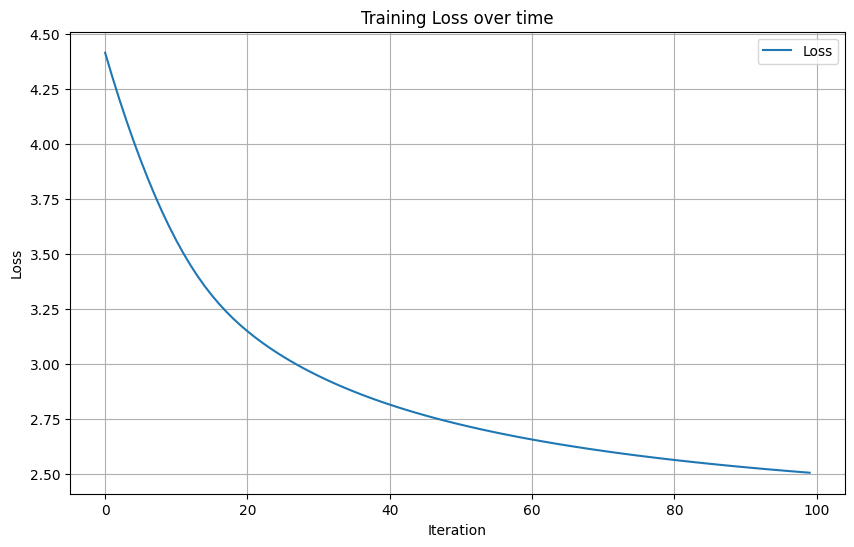

In [9]:
min_loss_storage = min(loss_storage)
plt.figure(figsize=(10, 6))
plt.plot(loss_storage, label="Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss over time")
plt.legend()
plt.grid(True)
plt.show()

In [105]:
class Trigram():
    def __init__(self,
                num_features, 
                num_outputs, 
                num_epochs, 
                learning_rate = 0.01,
                logging=False,
                regularize=False, 
                reg_smooth_strength=None, 
                seed=2147483647,
                enable_tqdm = True,
                *args,
                **kwargs):

       
        self.num_features = num_features
        self.num_outputs = num_outputs
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.regularize = regularize
        self.reg_smooth_strength = reg_smooth_strength
        
        self.enable_tqdm = enable_tqdm

        self.seed = seed
        self.g = torch.Generator().manual_seed(self.seed)
        self.weights = torch.randn((self.num_features, self.num_outputs), generator=self.g)
        self.weights.requires_grad = True

        print("Initialized weights shape: ", self.weights.shape)




    def __call__(self, x, y):
        """This is where we will compute the loss and store it"""

        xenc = F.one_hot(x,  num_classes = self.num_outputs).float().reshape(num, -1)
        
        #can also write W with 
        #W = torch.randn(self.num_features, 27), generator = g, requires_grad = True) 
        #print('trigram shape: ', x.shape)
        #print('Encoding shape: ', xenc.shape)
        #print("Weights shape: ", self.weights.shape)

        #This assert statements makes sure downstream dot product can happen
        assert xenc.shape[1] == self.weights.shape[0], "Check weights dimensions" #- failure
        
        logits = (xenc@self.weights) #This calculates neural network output

        #needs to transform logits to positive and then scale 
        counts = logits.exp()
        probs = counts / counts.sum(1, keepdims = True) #double check that we keep keepdims = True!

        loss = -probs[torch.arange(num), ys].log().mean()

        return loss

    def fit(self, x, y):
        loss_per_iter = []

        epoch_counter = tqdm(range(self.num_epochs)) if self.enable_tqdm else range(self.num_epochs)

        for epoch in epoch_counter:
            #Here we are calling __call__
            loss = self(x,y) 
            
            #Regularization attempt
            if self.regularize:
                loss += 0.01 * (self.weights**2).mean()
            else:
                pass

            self.weights.grad = None #reset the gradient for the weght matrix
            loss.backward() #do back propagation

            if epoch %10 == 0:
                print(f"Loss kth-iter {epoch + 1}: ", loss.item())
            
            loss_per_iter.append(loss.item())

            self.weights.data += -self.learning_rate *self.weights.grad #we want to use a negative value here as we continue to minimize the loss
        
        return loss_per_iter

    def makemore_samples(self, num_examples, itos):
        out = []
        for i in range(num_examples):
            out = []
            to_gen = [0,0]

            while True:
                xenc = F.one_hot(torch.tensor([to_gen]), num_classes = self.num_outputs).float().reshape(1, -1)
                logits = xenc@self.weights
                counts = logits.exp()
                probs = counts/counts.sum(1, keepdims = True)

                pred_input = torch.multinomial(probs, num_samples = 1, replacement = True, generator=self.g).item()

                to_gen = to_gen[1:] + [pred_input]
                new_char = itos[pred_input]
                out.append(new_char)

                if pred_input == 0:
                    break

            print(''.join(out))

In [106]:
words = open('./names.txt','r').read().splitlines()
all_chars = []
for w in words:
    all_chars += list(set(w))


#Alternative
# sorted(list(set(''.join(words)))) #alphabetical listing of all characters in the words
all_chars = list(set(all_chars))

stoi = {char:num for char, num in zip(sorted(all_chars), range(1, len(all_chars)+1))}
stoi['.'] = 0

itos = {i:s for s, i in stoi.items()}

In [107]:
#Create bigram training set
xs = []
ys = []

for w in words:
    chs = ['.'] + list(w) + ['.'] #adding start and end token to the word character
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        #print(f'Ch1: ', ch1)
        #print(f'Ch2: ', ch2)
        #print(f'Ch3: ', ch3)
        ix1 = stoi.get(ch1, 'ix1 missing')
        ix2 = stoi.get(ch2, 'ix2 missing')
        ix3 = stoi.get(ch3, 'ix3 missing')

        #print('-----')
        xs.append((ix1, ix2))
        ys.append(ix3)


xs = torch.tensor(xs)
ys = torch.tensor(ys)

#num varialb eis replaced with the desired outputs

print('Number of examples: ', num)
print('Xs shape ', xs.shape)

Number of examples:  196113
Xs shape  torch.Size([196113, 2])


In [108]:
##Initiate the trigram model
run_trigram = Trigram(num_features = 54,
                    num_outputs = 27,
                    num_epochs = 50,
                    learning_rate = 1,
                    reg_smooth_strength=0.01,
                    regularize=True,
                    seed = 2147483647)

Initialized weights shape:  torch.Size([54, 27])


  4%|▍         | 2/50 [00:00<00:13,  3.54it/s]

Loss kth-iter 1:  4.195971965789795


 24%|██▍       | 12/50 [00:01<00:04,  7.86it/s]

Loss kth-iter 11:  3.999877452850342


 44%|████▍     | 22/50 [00:03<00:03,  7.77it/s]

Loss kth-iter 21:  3.8271632194519043


 64%|██████▍   | 32/50 [00:05<00:02,  6.28it/s]

Loss kth-iter 31:  3.676630973815918


 84%|████████▍ | 42/50 [00:07<00:01,  6.33it/s]

Loss kth-iter 41:  3.5472300052642822


100%|██████████| 50/50 [00:08<00:00,  6.00it/s]


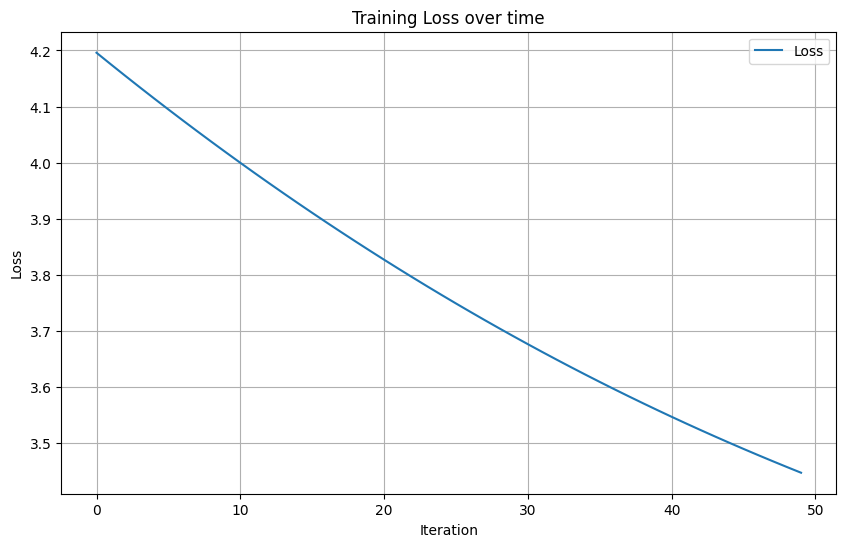

In [110]:
losses = run_trigram.fit(xs, ys)

min_loss_storage = min(losses)
plt.figure(figsize=(10, 6))
plt.plot(losses, label="Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Training Loss over time")
plt.legend()
plt.grid(True)
plt.show()

In [114]:
run_trigram.makemore_samples(num_examples=30, itos = itos)

nr.
gfnvabjxatan.
aemtansplvymyddvaiyqwwetdpmarrzwrt.
aennhmwbdkdhusni.
ziyddzqmraitaqxanemvxqpuocz.
.
kollinyndfj.
upfkbdfkbduncn.
o.
.
yewqxbemrwkxojxqzpgjlgtfwberollvaizpgxnws.
zoefzbduu.
yhh.
ggbdvaongbzonxpqsaelcmhhusjxsczdvjm.
oanrwekovdsvtaddzgksuccnanrbecanpwevbeqrwlpfkpgrlinhpkxdzisnl.
aolnzriianlfuh.
gyewa.
ooeaxstl.
ztmgunynhudyzgsdckvlig.
zgln.
ziptkogubsmzkpqm.
aeckchkpsacsnysiraer.
onzvvxoyzpyagjnb.
hh.
taktrkaabem.
gadudcn.
ziinhussjlelpgefbhbdlzbllhzgpwxfjdianbbmqxo.
pgbdlllwp.
jnvpwxzjfybdpwwh.
an.
